# Generating Petitions

### Training our own Transformer

For our first attempt, we'll train our own petition generator using a sample of ~15k UK Government petitions. We aim to create a model which generates text for a petition based on a short title.

In [1]:
import boto3
import json
import math
from timeit import default_timer as timer
import torch
import torch.nn as nn
from typing import Iterable, List
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch import Tensor
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [2]:
# Load the data
bucket = "petition-data"  # replace with your bucket name
key = "petitions.json"    # replace with your filename

s3client = boto3.client('s3')
response = s3client.get_object(Bucket=bucket, Key= key)
body = response['Body']

data = json.loads(body.read())
petitions = json.loads(data)

# The petition data consists of a description, a title, and number of signatures
display(petitions[0])

{'description': 'Many children and are choosing to live a life surrounded by the streets, drugs, and murders. This stems from poor education, the education system in the UK is outdated and boring. There needs to be a change to help children, give them confidence and knowledge of work skills.',
 'title': 'Introduce work-based subjects and practical skills into the schools in the UK.',
 'num_signatures': 127}

PyTorch uses Datasets and DataLoaders. Datasets are classes which allow individual samples to be retrieved, DataLoaders take care of batches. Models take DataLoaders as input.

A custom Dataset class must implement __init__ and __len__. A standard "map style" dataset must implement __getitem__, whilst an IterableDataset must implement __iter__.

https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd

In [3]:
# Create custom Dataset object
class IterablePetitionsDataset(torch.utils.data.IterableDataset):
    def __init__(self, data):
        super(IterablePetitionsDataset).__init__()
        self.data = data

    def __iter__(self):
        return iter(self.data)
    
    def __len__(self):
        return len(self.data)
    
# Organise our data to be a list of samples, each containing the petition title
# on the left (input) and description on the right (output)
data = [(p['title'], p['description']) for p in petitions]

# Split the data into train and validation (N.B the order of the data is already random)
data_valid = data[:2500]
data_train = data[2500:]

Next, we need to create our vocabulary from our training data. We'll also include special symbols in our vocab, which are expected by PyTorch later:

unk - 'unknown' - used in inference when an input word isn't in our vocabulary

pad - 'padding' - used to pad our word sequences to ensure consistent length

bos - 'beginning of string' - used to denote start of a sequence

eos - 'end of string' - used to denote end of a sequence

We won't do any case normalisation, stemming, stop-word removal, etc. These steps are useful in some language tasks, but when to generate realistic text we need to be able to generate full words, stop words, and upper case when appropriate.

In [4]:
# Create tokenizer
token_transform = get_tokenizer('spacy', language='en_core_web_sm')

# Function to yield a list of words from an iterable of text samples
def yield_tokens(data_iter: Iterable) -> List[str]:
    for data_sample in data_iter:
        # Use both the input and output texts (title and description)
        # to generate our vocab
        text = " ".join([data_sample[0], data_sample[1]])
        yield token_transform(text)

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Create vocab from training data
train_iter = IterablePetitionsDataset(data_train)
vocab_transform = build_vocab_from_iterator(yield_tokens(train_iter),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)


# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
vocab_transform.set_default_index(UNK_IDX)

# We now have a vocab - this is just a lookup which translates words into integers and vice versa
display(vocab_transform.lookup_indices(["Translate", "tokens", "to", "numbers"]))
display(vocab_transform.lookup_tokens([0, 29713, 6, 1037]))

[0, 29713, 6, 1037]

['<unk>', 'tokens', 'to', 'numbers']

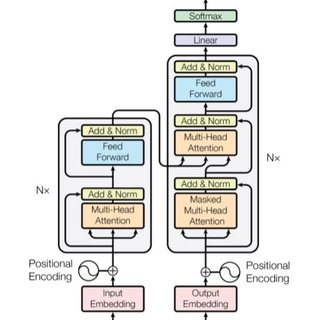

Now it's time to code the main elements of the Transformer.

In [5]:
# Ensure you run on a GPU if possible
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Input/Output Embedding #
# A module to embed a sequence - i.e. transform each word in the sequence into a vector
# This will give us a tensor representing the vector for each word in the sequence
# We'll use this module on each side of the Transformer (pink boxes above)
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Positional Encoding #
# A Module to add positional encoding to the token embedding in order to codify word order
# This is just calculating the sinusoids and adding the resulting tensor to the embedding tensor.
# There is also a standard dropout layer, and a line to save the positional embeddings
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])



# The full Transformer!
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

That Seq2SeqTransformer looks complicated, but the main bit is in the forward method. We apply token (word) embedding to the source and target sequences, followed by positional encoding. We then feed them both into the inbuilt Transformer module, along with some masks (which we'll get to next).

The encode and decode methods allow us to apply just the encoder or decoder parts of the architecture - these will be used after training to actually use the model. As per the architecure diagram, there is also a Linear layer topping off the Transformer.

Next we need to make two kinds of mask. One mask hides any padding tokens - we don't want to predict padding! The other mask hides the tokens in the target sequence which are right of the token we are predicting. i.e. - we don't want our model peeking at the answers while it's training!

In [6]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Next we define some parameters, such as the size of our token embeddings, the size of our batches, the number of encoder and decoder blocks we want to stack up, etc.

In [7]:
torch.manual_seed(0)

VOCAB_SIZE = len(vocab_transform)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Finally, we need some helper functions which we'll call when transforming a Dataset instance into a DataLoader instance. These will transform the raw sentences in our training data into tensors. The sentence will be tokenized (split into words), numericalized (each word is turned into a number), and then made into a tensor (during which we'll also add **bos** and **eos** tokens). We'll also pad out our sequences to ensure all source sequences in a given batch are equal length, and the same for target seuqnces.

In [8]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
text_transform = sequential_transforms(token_transform, #Tokenization
                                               vocab_transform, #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample.rstrip("\n")))
        tgt_batch.append(text_transform(tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Almost there! We need a function to train each epoch - this just turns out training data into batches of tensors (using the functions above), and then puts each batch through the model to update the model weights. A very similar function puts our validation through the model to calculate loss.

In [9]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = IterablePetitionsDataset(data_train)
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = IterablePetitionsDataset(data_valid)
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

And now we train!

In [11]:
NUM_EPOCHS = 30

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 8.074, Val loss: 6.982, Epoch time = 50.101s
Epoch: 2, Train loss: 6.777, Val loss: 6.500, Epoch time = 52.665s
Epoch: 3, Train loss: 6.284, Val loss: 6.153, Epoch time = 54.492s
Epoch: 4, Train loss: 5.979, Val loss: 5.984, Epoch time = 54.301s
Epoch: 5, Train loss: 5.781, Val loss: 5.880, Epoch time = 54.385s
Epoch: 6, Train loss: 5.630, Val loss: 5.819, Epoch time = 54.436s
Epoch: 7, Train loss: 5.501, Val loss: 5.776, Epoch time = 54.405s
Epoch: 8, Train loss: 5.386, Val loss: 5.740, Epoch time = 54.226s
Epoch: 9, Train loss: 5.279, Val loss: 5.715, Epoch time = 54.433s
Epoch: 10, Train loss: 5.181, Val loss: 5.692, Epoch time = 54.364s
Epoch: 11, Train loss: 5.085, Val loss: 5.682, Epoch time = 54.485s
Epoch: 12, Train loss: 4.988, Val loss: 5.670, Epoch time = 54.406s
Epoch: 13, Train loss: 4.897, Val loss: 5.660, Epoch time = 54.510s
Epoch: 14, Train loss: 4.814, Val loss: 5.671, Epoch time = 54.519s
Epoch: 15, Train loss: 4.732, Val loss: 5.661, Epoch time

In [377]:
# Save out model
torch.save(transformer.state_dict(), 'petiton_transformer_002')
response = s3client.upload_file('petiton_transformer_002', 'torch-models', 'petiton_transformer_002')

### Stepping through the model - validation

The training and validation can be quite mystifying - so let's take a single example through the model, end-to-end, to understand what's happening.

In [319]:
# Let's take an example from the validation data:
datapoint = data_valid[0]

display(datapoint)

('Introduce work-based subjects and practical skills into the schools in the UK.',
 'Many children and are choosing to live a life surrounded by the streets, drugs, and murders. This stems from poor education, the education system in the UK is outdated and boring. There needs to be a change to help children, give them confidence and knowledge of work skills.')

In [320]:
# Step 1: Translate a sentence into scalars

src_sentence = datapoint[0]
tgt_sentence = datapoint[1]

# Use our tokenizer and lookup from the start to change a sentence into words, and
# those words into integers
src_vec = text_transform(src_sentence)
tgt_vec = text_transform(tgt_sentence)

# Each input word is now a single number, and we also have spots for the full stop,
# <bos> and <eos>
display(src_vec.shape)
display(src_vec)
display(vocab_transform.lookup_tokens(list(src_vec)))

torch.Size([17])

tensor([   2,  238,  107,   26,  357, 2047,    7, 3239,  923,   96,    4,  125,
          11,    4,   19,    5,    3])

['<bos>',
 'Introduce',
 'work',
 '-',
 'based',
 'subjects',
 'and',
 'practical',
 'skills',
 'into',
 'the',
 'schools',
 'in',
 'the',
 'UK',
 '.',
 '<eos>']

In [321]:
# Step 2: Prepare our inputs and outputs, and create masks

# Convert our 1D vector to a 2D tensor; in a real run, this is unneccessary
# as the DataLoader returns the right dimensions
src = src_vec.unsqueeze(1)
tgt = tgt_vec.unsqueeze(1)

# Place onto the same device as the model
src = src.to(DEVICE)
tgt = tgt.to(DEVICE)

# We have to cut off the end token when inputting the target sequence, as there
# is no token after the final token for us to predict.
tgt_input = tgt[:-1, :]

# Create our masks
src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

# As we have a batch size of 1, both padding masks are redundant (we have no
# padding). The target mask is the important one - it is essentially a series of mask vectors.
# The first vector hides everything except the first token, so that we can predict the 
# second word. The second vector reveals the first two words, etc.
display(tgt_mask.shape)

for i in range(0,3):
    masked_target = tgt_input.reshape(1, tgt_mask.shape[0]) + tgt_mask[i]
    display(masked_target)

torch.Size([56, 56])

tensor([[2., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf]], device='cuda:0')

tensor([[  2., 201., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]], device='cuda:0')

tensor([[  2., 201.,  58., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]], device='cuda:0')

In [335]:
# Step 3: Get our logits

# Before running model, set some hooks
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

transformer.src_tok_emb.register_forward_hook(get_activation('src_tok_emb'))
transformer.tgt_tok_emb.register_forward_hook(get_activation('tgt_tok_emb'))

# Get logits
logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

# The resulting tensor gives us, for every masked variant of the input, a score for every possible
# next token. See that the tensor is size 56 (for the 56 target tokens, and therefore 56 masked variants), 
# by 1 (for a batch size of 1), by 30315 (the size of our vocab, to allow a probability per possible token)
display(logits.shape)
display(len(vocab_transform))

torch.Size([56, 1, 30315])

30315

What happened int hat last step? Our model took both our source sequence and target sequence, and outputted a set of un-normalised probabilities (logits). To do this, the model applied token and positional embedding to both source and target, and took both sequences through the various Linear layers and Attention modules.

Let's dig into these logits a bit more. I can pick the indices with the 5 greatest scores to determine the 3 most likely words to come after *bos*, for my given input.

In [336]:
# All pretty standard words - all capitalised as you'd expect for a starting word
display(vocab_transform.lookup_tokens(list(torch.topk(logits[0], 5).indices.tolist()[0])))

['The', 'As', 'I', 'We', 'Many']

I can look at a longer part of the target sequence to see what the next word might be.

In [337]:
def display_masked_target_and_predictions(i):
    masked_target = tgt_input.reshape(1, tgt_mask.shape[0]) + tgt_mask[i]
    unmasked_target_sequence = masked_target[0].tolist()[:i+1]
    unmasked_target_sequence = [int(x) for x in unmasked_target_sequence]

    print("\nMasked target: {}"
          .format(vocab_transform.lookup_tokens(unmasked_target_sequence)))

    print("Most propable next word: {}"
          .format(vocab_transform.lookup_tokens(list(torch.topk(logits[i], 5).indices.tolist()[0]))))
    
display_masked_target_and_predictions(0)
display_masked_target_and_predictions(1)
display_masked_target_and_predictions(2)
display_masked_target_and_predictions(3)
display_masked_target_and_predictions(4)


Masked target: ['<bos>']
Most propable next word: ['The', 'As', 'I', 'We', 'Many']

Masked target: ['<bos>', 'Many']
Most propable next word: ['schools', 'students', 'parents', 'young', 'children']

Masked target: ['<bos>', 'Many', 'children']
Most propable next word: ['are', 'in', 'do', 'have', 'across']

Masked target: ['<bos>', 'Many', 'children', 'and']
Most propable next word: ['school', 'young', 'their', 'parents', 'children']

Masked target: ['<bos>', 'Many', 'children', 'and', 'are']
Most propable next word: ['being', 'forced', 'not', 'expected', 'in']


We can see that the first prediction is not bad - the right answer is 5th most likely out of over 30k words. Same again for the next word. The predictins lean towards themes of school and children even before any such terms are revealed in the target sequence, so this is picked up from the source sequence, and the top predictions at each step make grammatical sense. 

In [338]:
# Step 4: Calculate loss

# Finally, we calculate the cross entropy loss. The logits are raw values, not propbabilities,
# but the inbuilt cross entropy loss function from PyTorch applies a Softmax behind the scenes.

loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

tensor(4.8950, device='cuda:0', grad_fn=<NllLossBackward0>)

And just out of interest, you can even get the embeddings of the source and target sequences (see that for each input word, we have a 512-length vector).

In [339]:
display(activation['src_tok_emb'].shape)
display(activation['tgt_tok_emb'].shape)

torch.Size([17, 1, 512])

torch.Size([56, 1, 512])

### Writing petitions

It's finally time to write some petitions!

As we saw before, we can predict probabilities for a "next" word based on both the entire source sequence and the target sequence up to that point. For creating new text, we essentialy do the same thing. Starting with a target that is simply **bos**, we predict probabilities for all possible first words. We then select the most likely word, and repeat the process, this time with a target that includes that chosen first word. We continue doing this until we either hit a maximum sequence length, or the token **eos** is predicted.

This approach is called greedy decoding. There are other options which make a tree of possible sequences and choose the most likely branch overall, but greedy is simplest.

In [341]:
# Function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

# Actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform(src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 100, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform.lookup_tokens(list(tgt_tokens.cpu().numpy())))

First, let's try our previous example from the validation set.

In [348]:
datapoint = data_valid[0]

print("\nActual title: " + datapoint[0])
print("\nActual description: " + datapoint[1])
print("\nPredicted description: " + translate(transformer, datapoint[0]))


Actual title: Introduce work-based subjects and practical skills into the schools in the UK.

Actual description: Many children and are choosing to live a life surrounded by the streets, drugs, and murders. This stems from poor education, the education system in the UK is outdated and boring. There needs to be a change to help children, give them confidence and knowledge of work skills.

Predicted description: <bos> The current curriculum for students , and school are not allowed to teach their children about their school , however , we are not taught about how to teach our children 's education . This is a problem that we do n't know what is a GCSE and we do n't know how to teach our children ? <eos>


Not bad! The prediction sticks to talking about education and mostly makes grammatical sense. It doesn't make a whole lot of **actual** sense, but that's what happens with a relatively small model and pretty small training data. Let's try another.

In [364]:
datapoint = data_valid[16]

print("\nActual title: " + datapoint[0])
print("\nActual description: " + datapoint[1])
print("\nPredicted description: " + translate(transformer, datapoint[0]))


Actual title: Give EU citizens working in the NHS free indefinite leave to remain in the UK.

Actual description: The possibility of a "no-deal" Brexit has been described as uncomfortably high. 
There are a significant number of EU citizens working in the NHS.  Any disruption in their working rights may have catastrophic effects. The government should give them indefinite leave to remain for free.


Predicted description: <bos> The UK should not be able to leave the EU after Brexit , as they are entitled to a referendum . 
 If we leave the EU , we can not afford to pay for free prescriptions , we should not be able to pay to pay for free movement of people who are entitled to pay . <eos>


Again, not too bad. We can definitely see some ropey ones though

In [367]:
datapoint = data_valid[12]

print("\nActual title: " + datapoint[0])
print("\nActual description: " + datapoint[1])
print("\nPredicted description: " + translate(transformer, datapoint[0]))


Actual title: To save the 16 remaining hospital beds at Okehampton Hospital

Actual description: The Clinical Commission Group are proposing to remove the 16 remaining hospital beds at Okehampton Hospital. Residents of Okehampton and the surrounding area, urge the retention of our local hospital beds. Okehampton is the hub of a huge rural area with a population of 20,000 people. .

Predicted description: <bos> The government has announced the government to cut the funding of the town of the town and the town of the town . 
 The government has to cut the funding of the town and the closure of the town of the town has to cut the town of the town . <eos>


This kind of repetition is a pretty classic issue in generating long text. Finally, let's try to make up some new titles

In [375]:
display(translate(transformer, "All children should learn computer science."))
display(translate(transformer, "Artificial intelligence should rule the country."))
display(translate(transformer, "The country should be ruled by AI."))

'<bos> The government should provide a better education for students to be able to provide their children for their children . <eos>'

'<bos> I believe that the current law should be a legal requirement to protect children from the country and learn about how to learn how much of the country is a good form of abuse . <eos>'

'<bos> The UK government must provide the use of human rights to protect animals from entering the UK to provide access to the use of development to use the use of development which allows the use of development to use their products to use by banning their use . <eos>'